In [1]:
!pip install keras-gpu

  Could not find a version that satisfies the requirement keras-gpu (from versions: )
No matching distribution found for keras-gpu
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install kaggle

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle.json" with length 62 bytes


In [0]:
rm -rf ./competitions/

In [5]:
!KAGGLE_CONFIG_DIR=`pwd` kaggle competitions download --force -c dogs-vs-cats-redux-kernels-edition

 95%|██████████████████████████████████████▉  | 258M/271M [00:01<00:00, 214MB/s]
100%|█████████████████████████████████████████| 271M/271M [00:01<00:00, 215MB/s]
100%|████████████████████████████████████████▉| 542M/544M [00:03<00:00, 135MB/s]
100%|█████████████████████████████████████████| 544M/544M [00:03<00:00, 162MB/s]
  0%|                                                | 0.00/111k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 111k/111k [00:00<00:00, 76.7MB/s]


In [0]:
!chmod 600 kaggle.json

In [0]:
!cd competitions/dogs-vs-cats-redux-kernels-edition/ && unzip -q train.zip && unzip -q test.zip

In [8]:
mv competitions/dogs-vs-cats-redux-kernels-edition/train ./data/ && mv competitions/dogs-vs-cats-redux-kernels-edition/test ./data/

mv: cannot move 'competitions/dogs-vs-cats-redux-kernels-edition/train' to './data/train': Directory not empty


In [0]:
cp competitions/dogs-vs-cats-redux-kernels-edition/sample_submission.csv ./data/

# Dogs vs. Cats

In [11]:
/.keras/models

SyntaxError: ignored

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [12]:
import numpy as np
import keras
from keras.models import Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [0]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [0]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [0]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

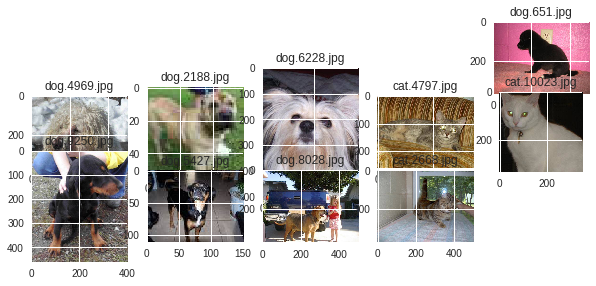

In [16]:
fig = plt.figure(figsize=(10, 5))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

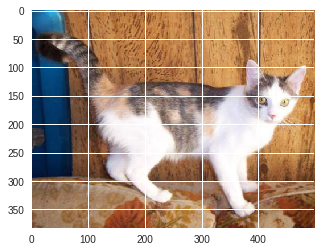

In [17]:
plt.imshow(plt.imread('./data/train/cat.707.jpg'))

## Загружаем предобученную модель

In [0]:
# base_model -  объект класса keras.models.Model (Functional Model)
# base_model = VGG16(include_top = False,
#                    weights = 'imagenet',
#                    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [0]:
base_model = InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
)

In [0]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [0]:
#base_model.summary()

## Добавляем полносвязный слой

In [0]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(64,  # один выход
#                 activation='sigmoid',  # функция активации  
#                 kernel_regularizer=keras.regularizers.l1(1e-4))(x)
# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [0]:
# model.summary()

## Компилируем модель и запускаем обучение

In [0]:
from keras import optimizers
adam = optimizers.Adam(lr=0.000001)

In [0]:
model.compile(# optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'],
              optimizer=adam)

In [33]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [34]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

print('Fitting...')
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=100,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data,
        #max_queue_size=10,
        #workers=8,
        #use_multiprocessing=True,
        verbose=2,
)

Fitting...
Epoch 1/100
 - 24s - loss: 0.1247 - acc: 0.9613 - val_loss: 0.0374 - val_acc: 1.0000
Epoch 2/100
 - 20s - loss: 0.1198 - acc: 0.9650 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 3/100
 - 20s - loss: 0.1155 - acc: 0.9666 - val_loss: 0.0362 - val_acc: 1.0000
Epoch 4/100
 - 20s - loss: 0.1184 - acc: 0.9647 - val_loss: 0.0326 - val_acc: 1.0000
Epoch 5/100
 - 20s - loss: 0.1250 - acc: 0.9619 - val_loss: 0.0360 - val_acc: 1.0000
Epoch 6/100
 - 20s - loss: 0.1216 - acc: 0.9609 - val_loss: 0.0451 - val_acc: 1.0000
Epoch 7/100
 - 20s - loss: 0.1304 - acc: 0.9562 - val_loss: 0.0344 - val_acc: 1.0000
Epoch 8/100
 - 20s - loss: 0.1244 - acc: 0.9609 - val_loss: 0.0350 - val_acc: 1.0000
Epoch 9/100
 - 20s - loss: 0.1289 - acc: 0.9628 - val_loss: 0.0355 - val_acc: 1.0000
Epoch 10/100
 - 20s - loss: 0.1210 - acc: 0.9619 - val_loss: 0.0390 - val_acc: 1.0000
Epoch 11/100
 - 20s - loss: 0.1184 - acc: 0.9653 - val_loss: 0.0383 - val_acc: 1.0000
Epoch 12/100
 - 20s - loss: 0.1119 - acc: 0.9647 - v

In [0]:
model.save('model_InceptionV3_gpu2.h5')

In [0]:
#model.load('model_InceptionV3_gpu.h5')

## Предсказания на проверочной выборке

In [37]:
pred = model.predict_generator(
    predict_generator(test_files),
    len(test_files),
    #max_queue_size=500,
    #workers=8,
    verbose=1
)

12500/12500 [==============================] - 542s 43ms/step


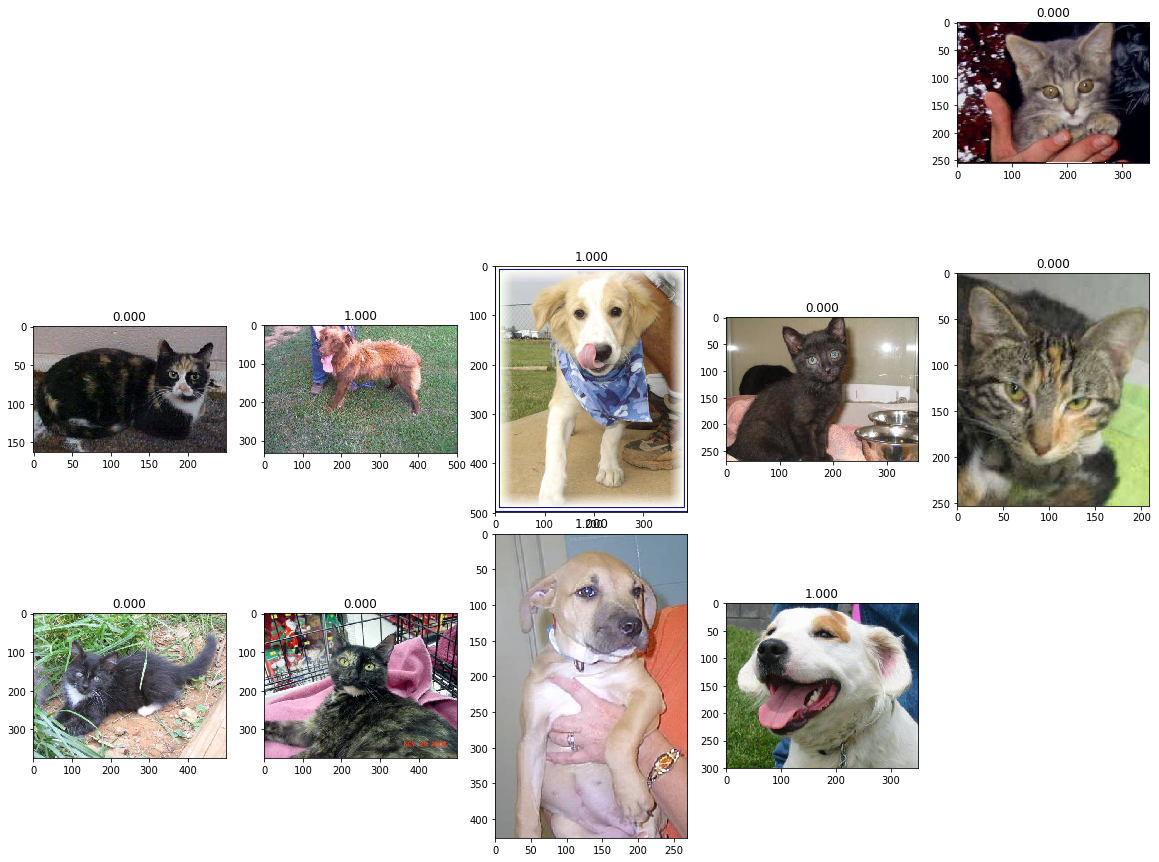

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [0]:
with open('submit2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score[0]))

In [0]:
files.download('submit2.txt')

In [36]:
ls -la submit2.txt

ls: cannot access 'submit2.txt': No such file or directory


In [0]:
# LogLoss = 1.04979

In [0]:
num_files = []
for path, score in zip(test_files, pred):
    if (score > 0.001 and score <= 0.01) or (score >= 0.99 and score < 0.999):
        num_file = int((re.search('(\d+)', path).group(0)))
        num_files.append((path, num_file, score[0]))

In [0]:
len(num_files)

83

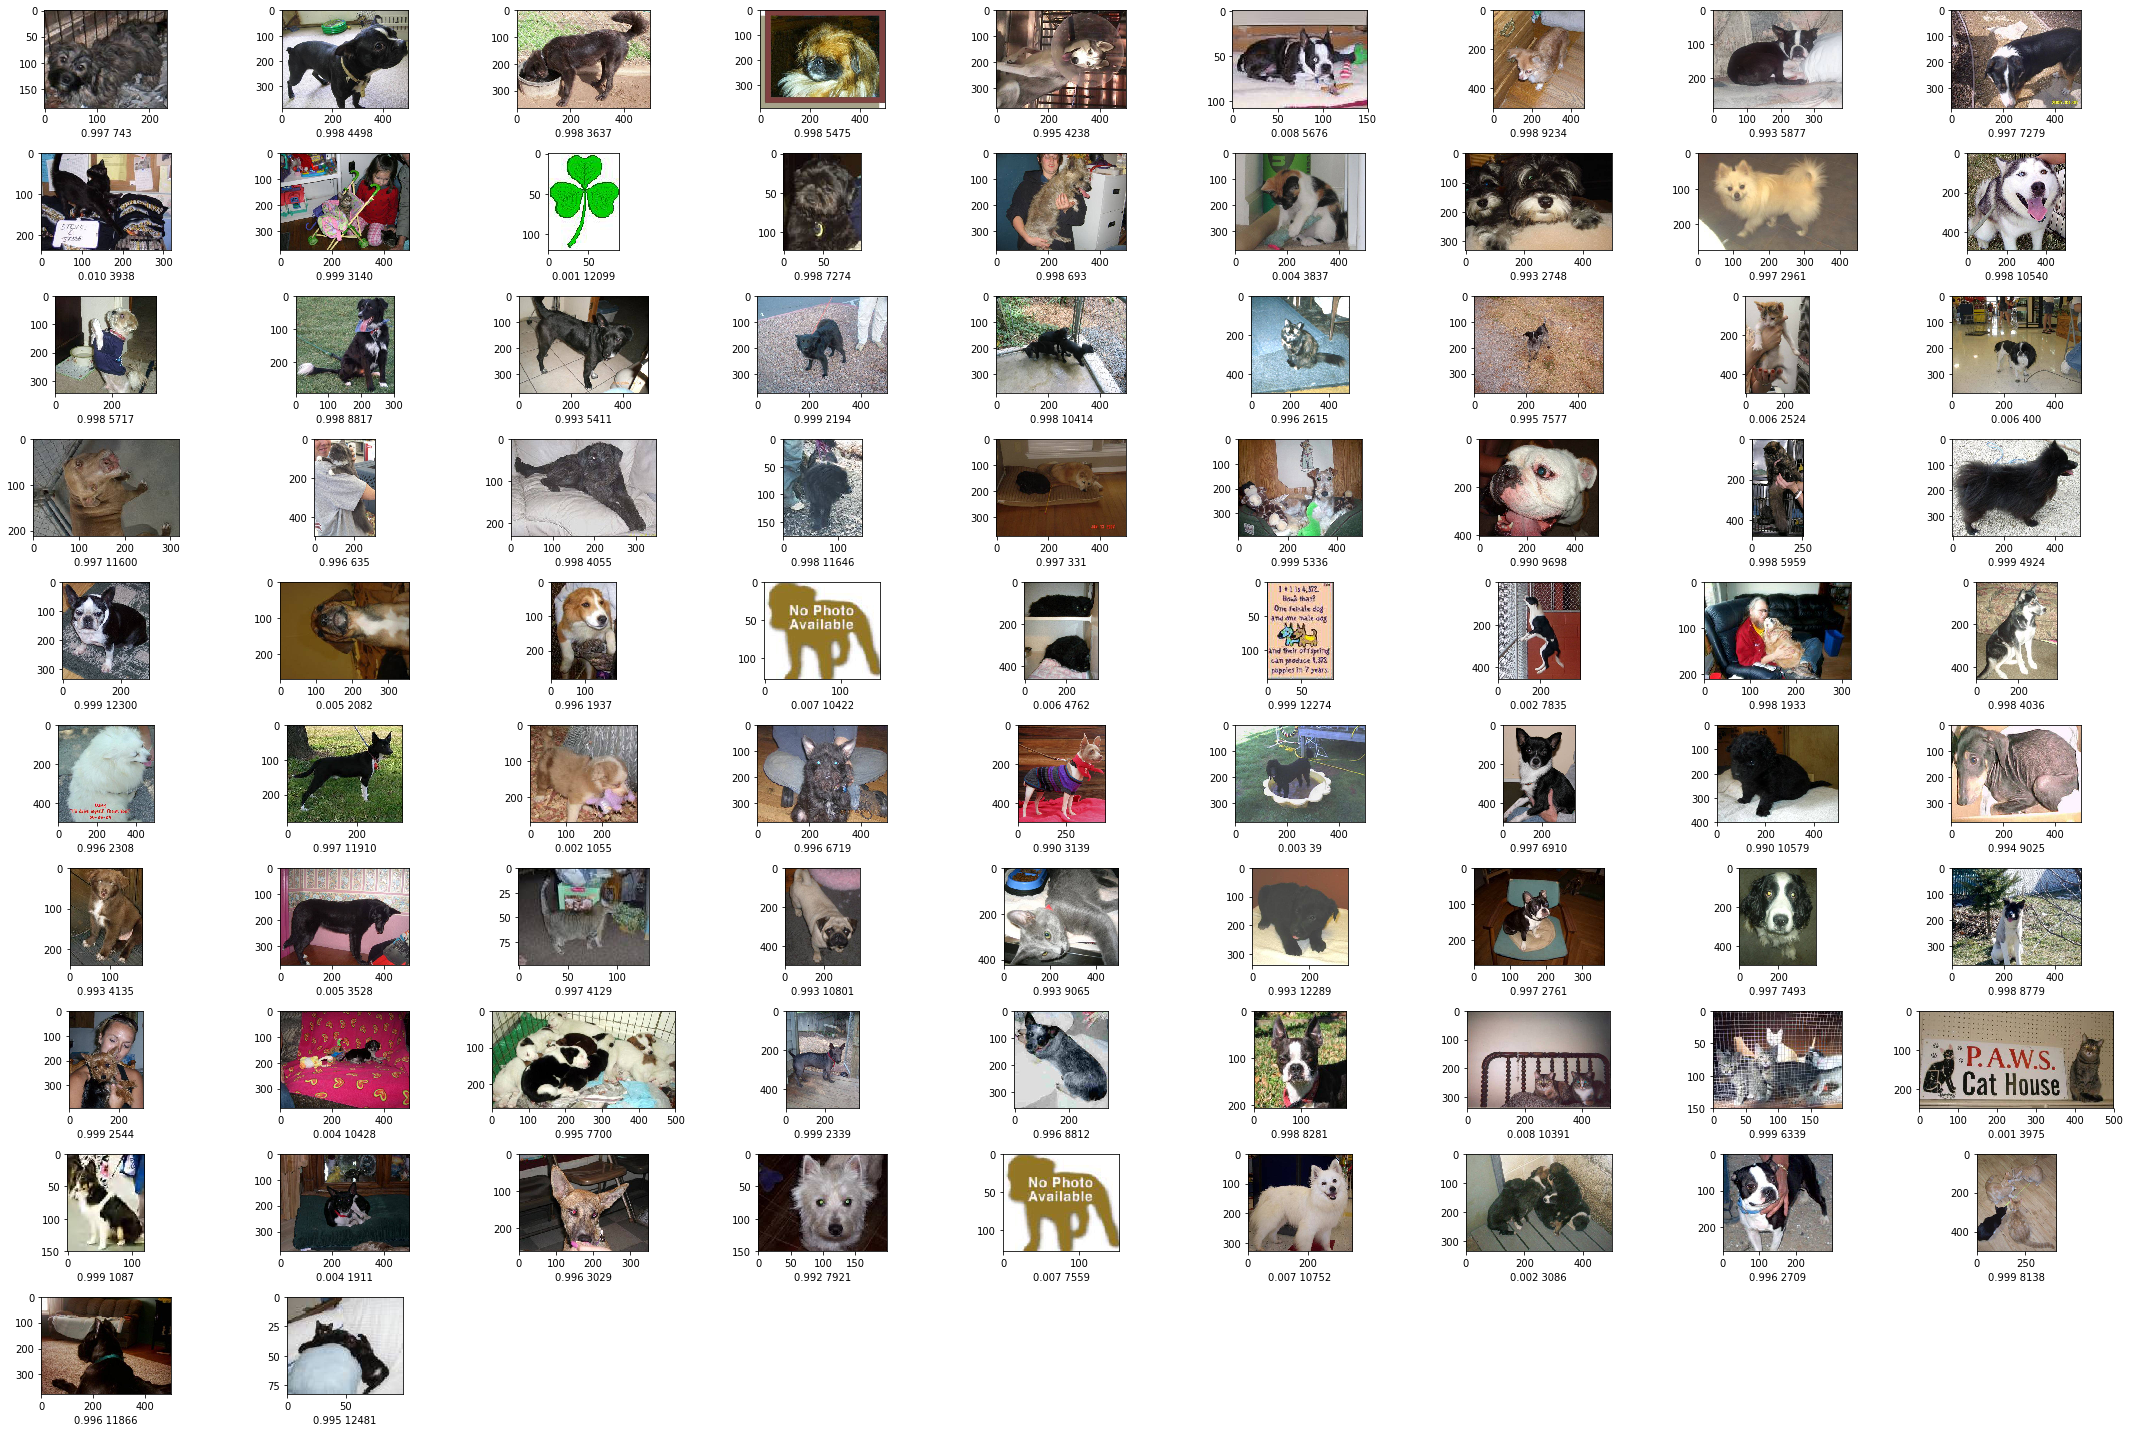

In [0]:
fig = plt.figure(figsize=(30, 20))
for i, (p, n, s) in enumerate(num_files, 1):
    ss = fig.add_subplot(10, 9, i)
    plt.imshow(plt.imread(p))
    ss.axes.set_xlabel(('%.3f %s' % (s, n)))
    plt.tight_layout()